# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

Import libraries:

In [1]:
!pip install -U scikit-learn==0.23

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-0.23.0-cp37-cp37m-manylinux1_x86_64.whl (7.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

sktime 0.8.1 requires scikit-learn>=0.24.0, but you'll have scikit-learn 0.23.0 which is incompatible.
sktime 0.8.1 requires statsmodels<=0.12.1, but you'll have statsmodels 0.12.2 which is incompatible.
pyldavis 3.3.1 requires numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
pycaret-ts-alpha 3.0.0.dev1636735356 requires scikit-learn~=0.24.2, but you'

In [2]:
!pip install --upgrade pandas

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /home/jovyan/.local/lib/python3.7/site-packages (1.3.4)


In [3]:
from pycaret.time_series import *

In [4]:
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

#rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


import logging, sys
logging.disable(sys.maxsize)

import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install pycaret-ts-alpha

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.0
    Uninstalling scikit-learn-0.23.0:
      Successfully uninstalled scikit-learn-0.23.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

sktime 0.8.1 requires statsmodels<=0.12.1, but you'll have statsmodels 0.12.2 which is incompatible.
pyldavis 3.3.1 requires numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.


In [6]:
#adjust display settings
%matplotlib inline
plt.rc('figure',figsize=(18,3))
plt.rcParams['figure.facecolor'] = 'w'

Load the data:

In [7]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


checking the table's structure:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


sort data by Datetime index, delete the index name

In [11]:
df.sort_index(inplace=True)
df.index.name= None

Resample the data by 1H and summing each hour since we need to know the amount of orders per hour.

In [12]:
df = df.resample('1H').sum()

## Analysis

plotting a simple plot to get an overview of the time series:

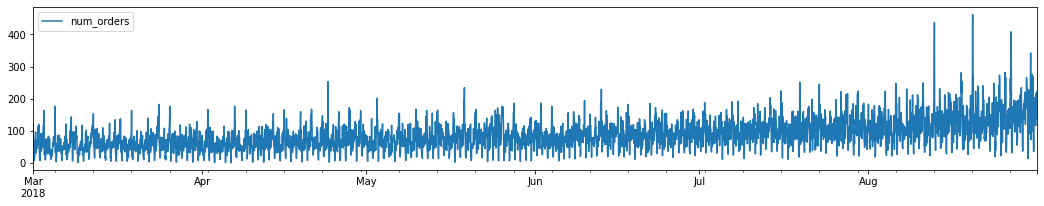

In [13]:
df.plot();

#### Description:
This plot shows the time series of our data.
We see that we have data from march to august.

decomposing and plotting the data to understand its components

In [14]:
decomposed = seasonal_decompose(df)

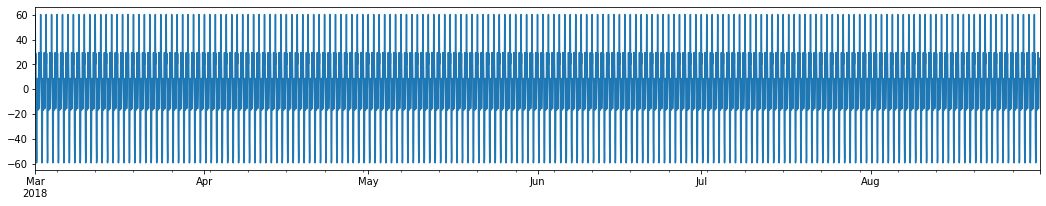

In [15]:
decomposed.seasonal.plot();

Since we cant understand anything from this plot, we will zoom in into august trying to figure out things more clearly:

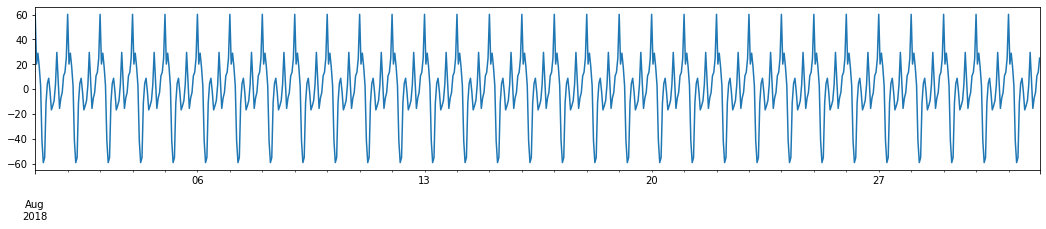

In [16]:
decomposed.seasonal['2018-08-01':'2018-08-31'].plot();

Zooming in to 2 day period to understand hourly seasionality as this is what matters in our task:

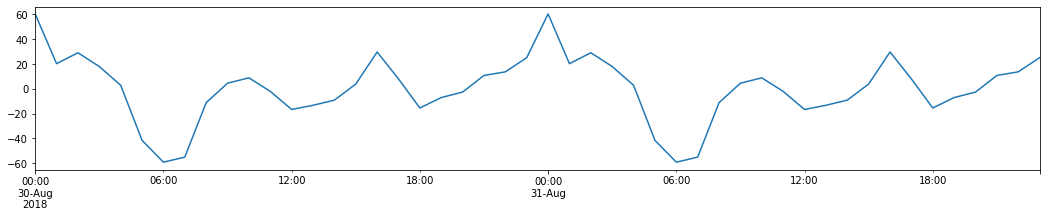

In [17]:
decomposed.seasonal['2018-08-30':'2018-08-31'].plot();

We can now see our cyclically repeating patterns (seasonality) regarding hourly orders clearer. 

#### Description:
- We can see that we gradually increase our num of orders from around 18:00 until midnight, and then the amount of orders decreases until 06:00.

creating a copy of the df without new features:

In [18]:
df2 = df.copy()
df2.head()

,num_orders
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Features creation:

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In order to determine how many lag features to add, we will use the plot_acf function.

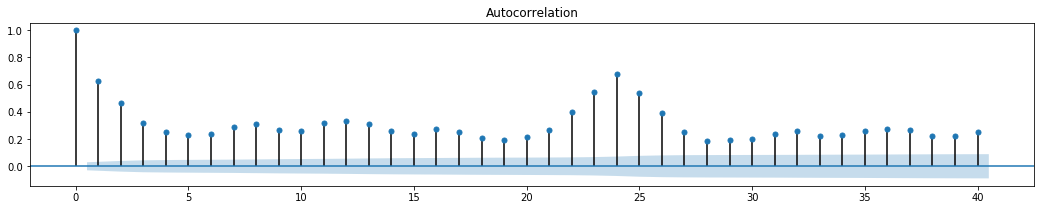

In [20]:
plot_acf(df,lags=40);

We will start by using 5 lags and rolling mean of 6 hours and adjust it if our RMSE won't satisfy us

In [21]:
make_features(df, 8, 6)

plotting the rolling mean:

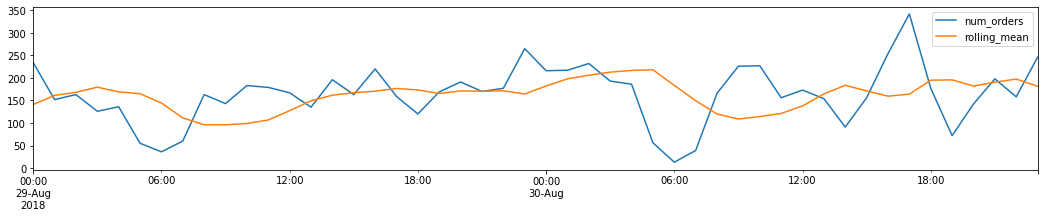

In [22]:
df['2018-08-29':'2018-08-30'][['num_orders', 'rolling_mean']].plot();

Making the data stationary:

In [23]:
#df -= df.shift()

## Training

splitting to train and test sets with test set being 0.1 of the data

In [24]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train2, test2 = train_test_split(df2, shuffle=False, test_size=0.1)

In [25]:
train = train.dropna()
X_train = train.drop('num_orders',axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### PyCaret

creating 10% of train set as validation set

In [26]:
test_size = 0.1 * len(train2)
test_size = int(test_size)

setting the forecasting horizon to 1 (1 hour):

In [27]:
setup(train2, fh = 1, fold = 3, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(3974, 1)"
2,Missing Values,False
3,Transformed Train Set,"(3973,)"
4,Transformed Test Set,"(1,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,24
9,Seasonality Detected,True


In [28]:
best = compare_models(sort='RMSE',exclude=['auto_arima'])

,Model,MAE,RMSE,MAPE,SMAPE,TT (Sec)
exp_smooth,Exponential Smoothing,19.2898,19.2898,0.1845,0.1611,0.6000
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,22.9627,22.9627,0.1668,0.1805,0.0600
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,27.1090,27.1090,0.2246,0.2179,0.1633
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,27.6084,27.6084,0.2162,0.2214,0.9433
naive,Naive Forecaster,27.6667,27.6667,0.2568,0.2168,0.0067
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,29.1101,29.1101,0.2553,0.2318,1.1667
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,29.5162,29.5162,0.2664,0.2360,1.1233
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,29.9371,29.9371,0.2894,0.2280,0.3867
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,31.7735,31.7735,0.2669,0.2543,2.8367
polytrend,Polynomial Trend Forecaster,33.1864,33.1864,0.2437,0.2685,0.0067


We continue with Exponential Smoothing as this is the best performing model regarding RMSE

finalzing ( fitting on entire train set)

In [29]:
%%time
final_exp_smooth = finalize_model(best);

CPU times: user 3.08 s, sys: 0 ns, total: 3.08 s
Wall time: 3.1 s


## Testing

predicting the next hour from the last value of the train set ( predicting the first value of the test set)

In [30]:
predict_1h = predict_model(final_exp_smooth).values

training RMSE for 1H prediction: (prediction from the last hour of training to real value (first value of test set))

In [31]:
print('RMSE of prediction of an hour from the test set: {}'.format(np.sqrt(mean_squared_error(test2.iloc[0], predict_1h))))

RMSE of prediction of an hour from the test set: 13.939899999999994


Lets try to predict an entire day of the test set and see what RMSE we get:

In [32]:
predict_24h= predict_model(final_exp_smooth, fh=24).values

In [33]:
print('RMSE of prediction of 24 hours from the test set: {}'.format(np.sqrt(mean_squared_error(test2.iloc[0:24], predict_24h))))

RMSE of prediction of 24 hours from the test set: 38.14058898094435


Forecasting the entire test set:

In [34]:
final_exp_smooth

ExponentialSmoothing(damped_trend=False, initial_level=None,
                     initial_seasonal=None, initial_trend=None,
                     initialization_method='estimated', seasonal='add', sp=24,
                     trend='add', use_boxcox=None)

In [35]:
predict_test= predict_model(final_exp_smooth, fh=len(test2)).values

In [36]:
print('RMSE of prediction of an entire day from the test set: {}'.format(np.sqrt(mean_squared_error(test2.values, predict_test))))

RMSE of prediction of an entire day from the test set: 40.44866194209917


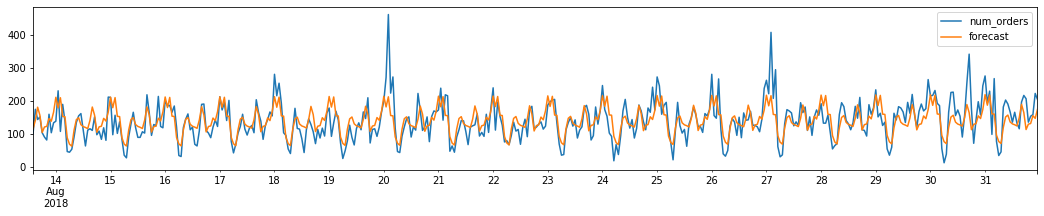

In [38]:
test2['forecast'] = predict_test
test2.plot();

### Conclusions:

- We managed to achieve RMSE of 40.4 for predicting the entire test set.

- Our used and best performing model is Exponential Smoothing
